# Случайный лес

# Итоговое задание №2. Прогнозирование конечных свойств новых материалов (композиционных материалов)
На входе имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов. 

Предсказание (из семинара 22): 
* модуль упругости при растяжении
* прочности при растяжении
* cоотношение матрица-наполнитель

Предсказание (из итогового вебинара 26.11.2022):
* модуль упругости при растяжении
* прочности при растяжении

In [21]:
import numpy as np
import pandas as pd

In [22]:
# считывание данных из файла
def load_simple_df(full_nm_str):
    sdf = pd.read_csv('../data/interim/'+full_nm_str+'.csv', sep=';',index_col=0) # Загрузка и создание датафрейма из csv файла
    return sdf

#считывание всех наборов для одного из целевых показателей
def load_data(nm_str):
    x_train = load_simple_df('X_train_'+nm_str)
    y_train = load_simple_df('y_train_'+nm_str)
    x_test = load_simple_df('X_test_'+nm_str)
    y_test=load_simple_df('y_test_'+nm_str)
    x_val=load_simple_df('X_val_'+nm_str)
    y_val=load_simple_df('y_val_'+nm_str)
    return (x_train, y_train, x_test, y_test, x_val, y_val)

Случайный лес

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [24]:
# тренировка модели Случайный лес
def try_rfr(x_train, y_train, x_val, y_val):
    rfr_model = RandomForestRegressor(random_state=14)
    rfr_model_params = {#'n_estimators' : range(1, 100, 5),
                        #'max_features': ['auto', 'sqrt', 'log2'],
                        #'max_depth' : range(1, 5, 1),
                        #'criterion':['mse']}
                        'n_estimators': [100, 200, 500],
                        'max_features': ['auto', 'sqrt', 'log2'],
                        'max_depth' : [4,5,6],
                        'criterion' :['squared_error']}
    GSCV_rfr = GridSearchCV(rfr_model, rfr_model_params, cv=5, verbose=2)   
    GSCV_rfr.fit(x_train, y_train)
    rfr_model_predict = GSCV_rfr.best_estimator_
    rfr_best_params = GSCV_rfr.best_params_
    
    MSE = mean_squared_error(y_val, rfr_model_predict.predict(x_val))
    R2 = r2_score(y_val, rfr_model_predict.predict(x_val))

    return (MSE, R2, rfr_model_predict, rfr_best_params)
    

In [25]:
#запуск модели Случайный лес и вычисление метрик
def fit_rfr(nm_file_str, nm_error_df_str):
    #считываем данные из файлов
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_df = pd.DataFrame()
    x_val_df = pd.DataFrame()
    y_val_df = pd.DataFrame()

    (x_train_df, y_train_df, x_test_df, y_test_df, x_val_df, y_val_df) = load_data(nm_file_str)

    #обучаем модель
    (MSE, R2, prediction_y_rfr, params_y_rfr) = try_rfr(x_train_df, y_train_df, x_val_df, y_val_df)
    neigh_errors = pd.DataFrame({'model_name':'RandomForest',
                              'target_var':[nm_error_df_str],
                              'MSE':[MSE],
                              'R2':[R2]})
    return (neigh_errors, x_val_df, y_val_df, prediction_y_rfr, params_y_rfr)

In [26]:
#визуализация
import matplotlib.pyplot as plt

def actual_and_predicted_plot(orig, predict, var, model_name):
    plt.figure(figsize=(17,5))
    plt.title(f'Валидационные и прогнозные значения: {model_name}')
    plt.plot(orig, label='Валидация')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

Для каждой характеристики запускаем последовательно обучение моделей

In [ ]:
#датасет со значениями ошибок
errors_df = pd.DataFrame(columns=['target_var','model_name','MSE','R2'])

(fit_errors, x_val_elastic, y_val_elastic, y_elastic_predict, y_elastic_params_rfr) = fit_rfr('elastic', 'Модуль упругости при растяжении, ГПа')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
(fit_errors, x_val_strength, y_val_strength, y_strength_predict, y_strength_params_rfr) = fit_rfr('strength', 'Прочность при растяжении, МПа')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
(fit_errors, x_val_matrix, y_val_matrix, y_matrix_predict, y_matrix_params_rfr) = fit_rfr('matrix', 'Соотношение матрица-наполнитель')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
errors_df

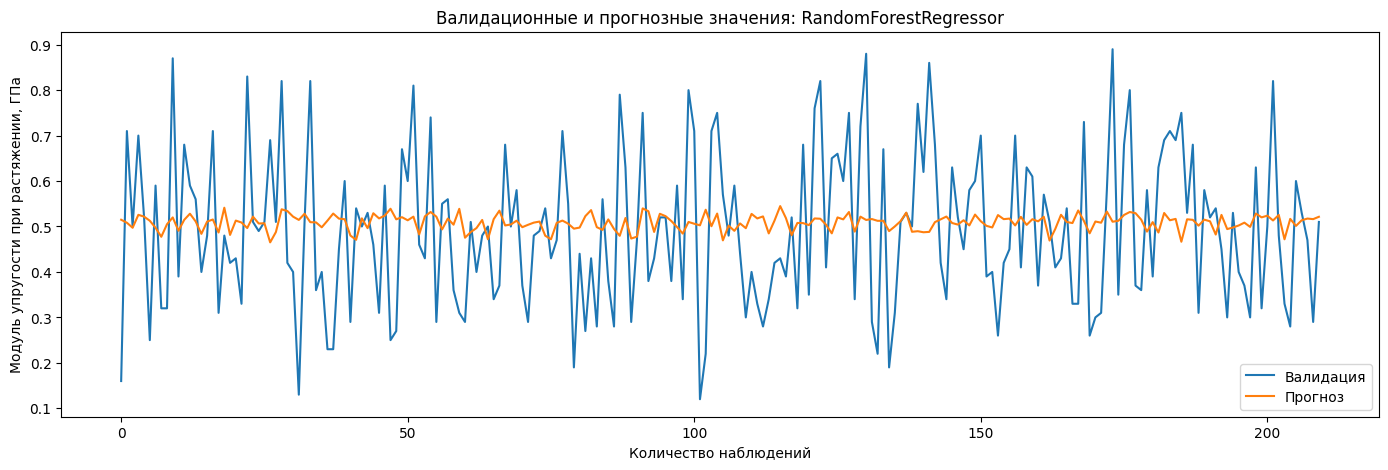

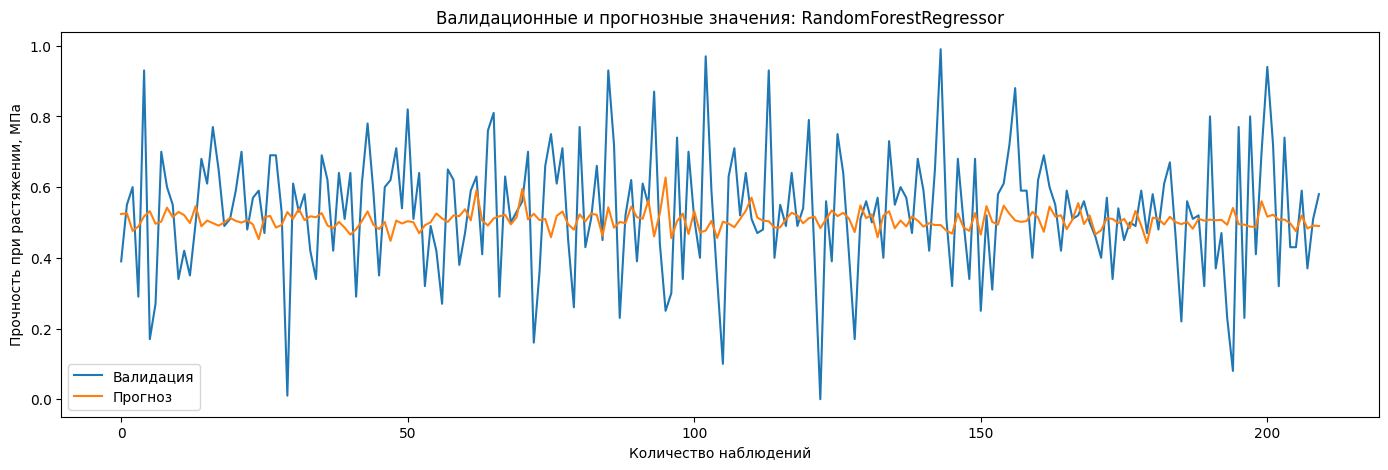

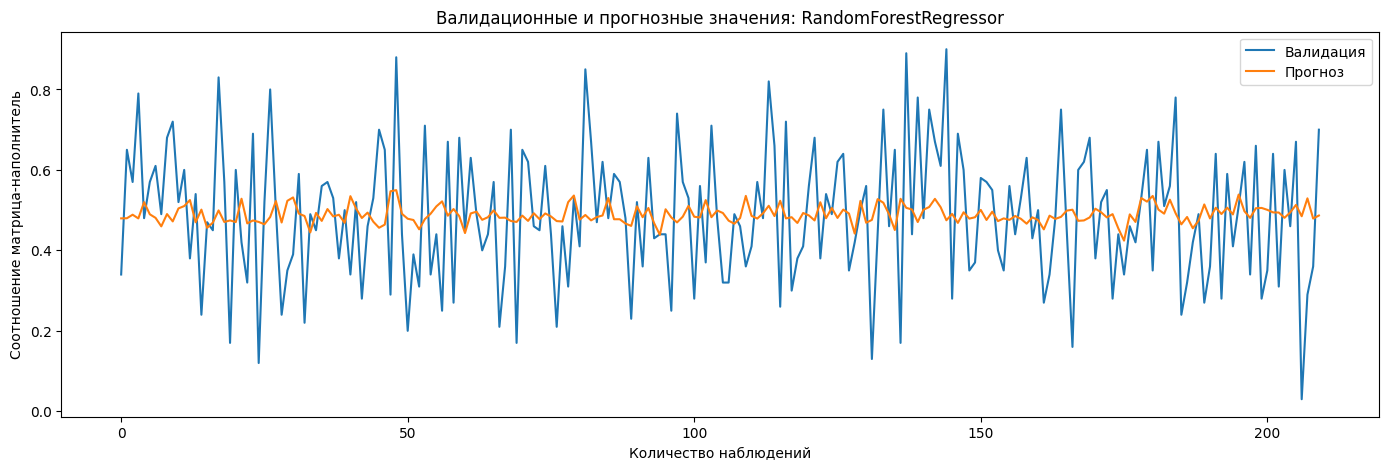

In [29]:
actual_and_predicted_plot(y_val_elastic.values,
                            y_elastic_predict.predict(x_val_elastic), 
                            'Модуль упругости при растяжении, ГПа',
                            'RandomForestRegressor')
actual_and_predicted_plot(y_val_strength.values,
                            y_strength_predict.predict(x_val_strength), 
                            'Прочность при растяжении, МПа', 
                            'RandomForestRegressor')
actual_and_predicted_plot(y_val_matrix.values,
                            y_matrix_predict.predict(x_val_matrix), 
                            'Соотношение матрица-наполнитель', 
                            'RandomForestRegressor')

Все плохо. Выводить наилучшие параметры для донастройки модели - бессмысленно

#y_elastic_params_rfr
#y_elastic_predict

Возможные направления дальнейших исследований:
1. тонкая настройка модели, либо
2. рассмотрение гипотезы, что модели ведут себя по-разному для разных классов композитов, поэтому вначале выполнить задачу кластеризации, затем рассмотреть разные кластеры алгоритмами ML, либо 
3. рассмотреть гипотезу, что взаимосвязи между собранными значениями отсутствуют и искать новые комбинации характеристик композитов